https://sigopt.com/blog/comparison-bayesian-packages-hyperparameter-optimization/  
https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html  

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

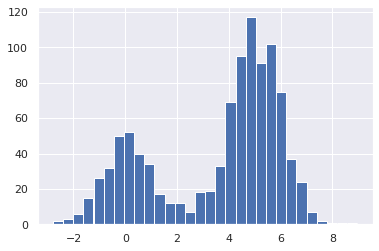

In [19]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)
hist = plt.hist(x, bins=30)

In [32]:
# export
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial

def _objective_kde_best_bw(trial, x1d=None):
    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import train_test_split

    # hyper parameter
    bandwidth = trial.suggest_float('bw', 0, 1)
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    
    # cross validation
    assert x1d is not None, 'Dataset is not provided'
    X = x1d[:, None]
    x_train, x_test = train_test_split(X, test_size = 0.8)
    
    # fit
    kde.fit(x_train)
    
    # loss function to minimize
    loglikelihood = kde.score_samples(x_test)
    # minimize the negative log loss of the likelihood
    #    'AND' of sample's probs should account the same
    #    thus, joint prob they all match
    #    negate to minimize objective
    neglogloss = -1 * np.sum(loglikelihood)
    return neglogloss

def estimate_kde(x1d, return_study=False):
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # attach dataset to objective
    objective = partial(_objective_kde_best_bw, x1d=x1d)

    # search
    study = optuna.create_study()
    study.optimize(objective, n_trials=400)

    # instantiate and fit the KDE model
    from sklearn.neighbors import KernelDensity
    bandwidth=study.best_params['bw'] # E.g. {'x': 2.002108042}
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(x1d[:, None])

    if return_study:
        return kde, study  
    else:
        return kde

In [21]:
kde, study = estimate_kde(x, return_study=True)
linspace=np.linspace(-4, 8, 1000)

In [26]:
# export
def get_linspace_from_kde(kde):
    arr = np.asarray(kde.tree_.node_bounds).ravel()
    N = 1000 # arr.shape[0]
    margin = (arr.max()-arr.min()) * 0.10
    return np.linspace(arr.min() - margin, arr.max() + margin, N)

In [27]:
# export
def plot_kde(kde, linspace=None, x=None):
    if linspace == None:
        linspace = get_linspace_from_kde(kde)

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(linspace[:, None])

    plt.fill_between(linspace, np.exp(logprob), alpha=0.5)
    if x is not None:
        plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    # plt.ylim(-0.02, 0.4)

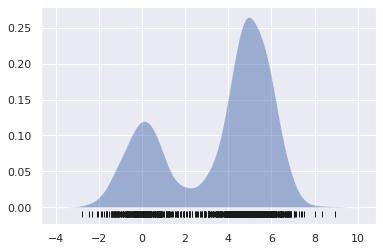

In [28]:
plot_kde(kde, x=x)

In [33]:
# export
def cdf_from_kde(kde, linspace=None):
    if linspace == None:
        linspace = get_linspace_from_kde(kde)
    logprob = kde.score_samples(linspace[:, None])
    cdf_raw=np.exp(logprob).cumsum()
    cdf=cdf_raw/cdf_raw[-1] #normalize

    return pd.Series(index=linspace, data=cdf, name='cdf')

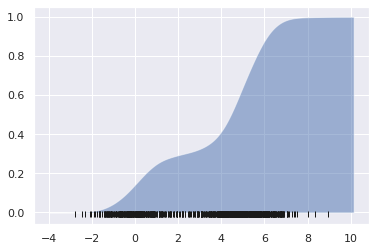

In [35]:
cdf=cdf_from_kde(kde)
plt.fill_between(cdf.index, cdf.values, alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
# cdf

In [38]:
# export
def pval_from_cdf(x, cdf):
    linspace = cdf.index
    values = cdf.values    
    if x >= linspace[-1]:
        # higher value that we ever seen
        return 1.0
    else:
        idx=np.argmax(linspace>x)
        return values[idx]

In [39]:
pval_from_cdf(0, cdf), pval_from_cdf(5, cdf), pval_from_cdf(7, cdf), pval_from_cdf(9, cdf)

(0.14311127320738393,
 0.644469196076236,
 0.9825423699823718,
 0.9995173713532973)

In [41]:
import optuna
# optuna.visualization.plot_slice(study)

In [40]:
from python_aux import notebook2script
notebook2script('optuna_cv.ipynb')

Converted optuna_cv.ipynb to ../src/optuna_cv.py
